In [30]:
using NiLang, NiLang.AD
using LinearAlgebra
using DelimitedFiles
using Plots
using Distributions
using BenchmarkTools
include("Adam.jl")

gclip! (generic function with 1 method)

In [2]:
struct Linear{T}
    W1::Matrix{T}
    b1::Vector{T}
    y1::Vector{T}
    y1a::Vector{T}
end
NiLang.AD.GVar(x::Linear) = Linear(GVar(x.W1), GVar(x.b1),GVar(x.y1), GVar(x.y1a));

In [3]:
"""Apply a single linear transformation."""
@i function linear_layer!(x::AbstractVector{T}, layer::Linear{T},y!::AbstractVector{T};method="relu") where T
    @routine @invcheckoff begin
        i_affine!(layer.y1, layer.W1, layer.b1, x)
        end
    
        @inbounds for i=1:length(layer.y1)
            if (method=="relu", ~)
                if (layer.y1[i] >= 0, ~)
                    y![i] += layer.y1[i]
                    layer.y1a[i] += layer.y1[i]
                end
            else
                y![i] += tanh(layer.y1[i])
                layer.y1a[i] +=  tanh(layer.y1[i])
            end
        end
    ~@routine
    ## clean up accumulated rounding error, since this memory is reused.
    @safe layer.y1 .= zero(T)
end

In [4]:
"""Apply a single linear transformation."""
@i function linear_layer!(x::AbstractVector{T}, layer::Linear{T};method="relu") where T
    @routine @invcheckoff begin
        i_affine!(layer.y1, layer.W1, layer.b1, x)
        end
    
        @inbounds for i=1:length(layer.y1)
            if (method=="relu", ~)
                if (layer.y1[i] >= 0, ~)
                    layer.y1a[i] += layer.y1[i]
                end
            else
                layer.y1a[i] +=  tanh(layer.y1[i])
            end
        end
    ~@routine
    @safe layer.y1 .= zero(T)
end

In [5]:
const LinearNetwork{T} = Vector{Linear{T}}


Array{Linear{T},1} where T

In [6]:
@i function Linear_network!(x!::AbstractVector{T}, network::LinearNetwork{T},y!::AbstractVector{T}) where T
    @invcheckoff for i=1:length(network)
        if (i==length(network), ~)
            @inbounds linear_layer!(network[i-1].y1a, network[i], y!,method="tanh")
        else
            if (i==1, ~)
                @inbounds linear_layer!(x!, network[i],method="relu")
            else
                @inbounds linear_layer!(network[i-1].y1a, network[i],method="relu")
            end
        end
    end
end

In [7]:
function random_Linear_network(nparams::Int, nhidden::Int)
    random_Linear_network(Float64, nin, nhidden)
end


random_Linear_network (generic function with 1 method)

In [8]:
function random_Linear_network(::Type{T}, nin::Int, nhidden::Int) where T
    y1 = zeros(T, nhidden)
    model=Linear{T}[]
    push!(model,Linear{T}(randn(T,  nhidden, nin), randn(T, nhidden),zeros(Float64, nhidden),zeros(Float64, nhidden)))
    push!(model,Linear{T}(randn(T,  nhidden, nhidden), randn(T, nhidden),zeros(Float64, nhidden),zeros(Float64, nhidden)))
    push!(model,Linear{T}(randn(Float64, 1, nhidden), randn(Float64, 1),zeros(Float64, 1),zeros(Float64, 1)))
    return model
end

random_Linear_network (generic function with 2 methods)

In [33]:
x=randn(Float64,1);
model = random_Linear_network(Float64, 1, 64);
model


3-element Array{Linear{Float64},1}:
 Linear{Float64}([0.34066379389330387; 0.03655141068216427; … ; 0.29769252419506276; -0.38783288272845134], [-0.7896461257651173, -1.0785377762463966, 0.29303887441309995, -1.502377906657609, -0.016430410055011783, 1.112491955227989, 0.18395047344966406, 0.2055322131221128, 0.9605302502335613, -0.15543111980050406  …  -0.9706616692442986, -0.5581520326547871, 0.016077788400614232, -0.2291326450278882, -0.11546753212686375, 1.3894576608203641, 0.15520013845554537, -0.8088401150358574, -1.350499319748895, -0.4762636595662629], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Linear{Float64}([-0.31923519094237807 0.4193268952077571 … 1.3495928222870863 1.4230033835630767; -2.4470948897577536 -1.9934133679647577 … 1.2933285899368463 0.40083217493307716; … ; -2.448468492342583 -2.090449277948966 

In [10]:
y=[0.0]
x,model,y=Linear_network!(x, model,y);
model 

3-element Array{Linear{Float64},1}:
 Linear{Float64}([-0.23377692595382346; -1.876082723373444; … ; -0.2775782830846358; 1.0053963637200165], [2.0587233344301987, 0.9930586059012015, -0.07828060073198712, -0.8457104874430017, 1.5102760601399494, -0.9755229725761865, 1.3780828405677572, 1.3597599619565246, -1.1018196870775159, -0.01836633845996827  …  1.1305679594325972, -0.2975122809672922, 0.8672320631560677, 1.0400925808179267, -0.3082907917506283, 0.38223192483926416, -1.3132609176250156, -0.21045252078193188, 1.5577639361920386, 1.5066085690981927], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.3083485637546186, 2.996325515768013, 0.9249928809945924, 0.0, 1.8962766639427335, 0.39629672920592895, 0.9842016096026227, 1.3990235218659324, 0.0, 1.3769462360467324  …  2.8363516206904444, 0.0, 2.1424172539670607, 0.0, 0.0, 0.0, 0.0, 0.03437999813047443, 1.854159922612732, 0.4330539535964042])
 Linear{Float64}([0.017005655742421

In [11]:
x,model,y=(~Linear_network!)(x, model,y); 

In [12]:
model

3-element Array{Linear{Float64},1}:
 Linear{Float64}([-0.23377692595382346; -1.876082723373444; … ; -0.2775782830846358; 1.0053963637200165], [2.0587233344301987, 0.9930586059012015, -0.07828060073198712, -0.8457104874430017, 1.5102760601399494, -0.9755229725761865, 1.3780828405677572, 1.3597599619565246, -1.1018196870775159, -0.01836633845996827  …  1.1305679594325972, -0.2975122809672922, 0.8672320631560677, 1.0400925808179267, -0.3082907917506283, 0.38223192483926416, -1.3132609176250156, -0.21045252078193188, 1.5577639361920386, 1.5066085690981927], [-2.7755575615628914e-17, 0.0, 0.0, 0.0, 0.0, 0.0, -5.551115123125783e-17, -1.1102230246251565e-16, 0.0, 0.0  …  2.220446049250313e-16, 0.0, 2.220446049250313e-16, 0.0, 0.0, 0.0, 0.0, 0.0, -5.551115123125783e-17, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Linear{Float64}([0.017005655742421546 0.7624922598177527 … -0.30904813403391534 -0.8421282372750477; -2.48277627874

In [13]:
nparameters(n::Linear) = length(n.W1) + length(n.b1)
nparameters(n::LinearNetwork) = sum(nparameters, n)

nparameters (generic function with 2 methods)

In [14]:
"""collect parameters in the `layer` into a vector `out`."""
function collect_params!(out, layer::Linear)
    a, b= length(layer.W1), length(layer.b1)
    out[1:a] .= vec(layer.W1)
    out[a+1:a+b] .= layer.b1
    return out
end

collect_params!

In [15]:
function dispatch_params!(layer::Linear, out)
    a, b= length(layer.W1), length(layer.b1)
    vec(layer.W1) .= out[1:a]
    layer.b1 .= out[a+1:a+b]
    return layer
end

dispatch_params! (generic function with 1 method)

In [16]:
function collect_params(n::LinearNetwork)
    out = zeros(Float64, nparameters(n))
    k = 0
    for layer in n
        np = nparameters(layer)
        collect_params!(view(out, k+1:k+np), layer)
        k += np
    end
    return out
end

collect_params (generic function with 1 method)

In [17]:
function dispatch_params!(network::LinearNetwork, out)
    k = 0
    for layer in network
        np = nparameters(layer)
        dispatch_params!(layer, view(out, k+1:k+np))
        k += np
    end
    return network
end

dispatch_params! (generic function with 2 methods)

In [18]:
struct SineWave
    amplitude::Float32
    phase_shift::Float32
end
SineWave() = SineWave(rand(Uniform(0.1, 5)), rand(Uniform(0, 2pi)))

(s::SineWave)(x::AbstractArray) = s.amplitude .* sin.(x .+ s.phase_shift)

function Base.show(io::IO, s::SineWave)
    print(io, "SineWave(amplitude = ", s.amplitude, ", phase shift = ", s.phase_shift, ")")
end

In [19]:
wave = SineWave(4, 1)


SineWave(amplitude = 4.0, phase shift = 1.0)

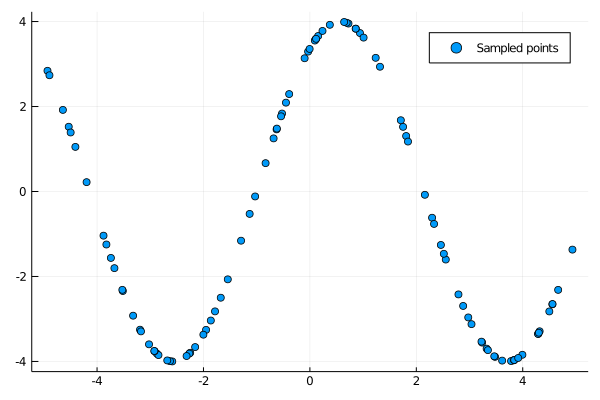

In [52]:
x = rand(Uniform(-5, 5), 100);
y = wave(x);
model = random_Linear_network(Float64, 1, 64);
scatter(x,y,label="Sampled points")

In [46]:
nparameters(model)

4353

In [22]:
@i function loss!(out!::T, x!::AbstractVector{T}, y!::AbstractVector{T},z!::AbstractVector{T},model::LinearNetwork) where T
    for i = 1:length(x!)
        @routine begin
            @zeros T anc1 anc2
            Linear_network!(x![i:i], model,z!)
            anc1 += z![1]-y![i]
            anc2 += anc1 ^ 2
            (~Linear_network!)(x![i:i], model,z!) 
        end
        out! += anc2
        ~@routine
        @safe z!.= zero(T)
    end
end

In [23]:
function loss2(out::T, x::AbstractVector{T}, y::AbstractVector{T},model::LinearNetwork) where T
     for i = 1:length(x)
        z=[0.0]
        _,model,z=Linear_network!(x[i:i], model,z)
        out += (z[1]-y[i])^2
        _,model,z=(~Linear_network!)(x[i:i], model,z)
    end
    return out
end

loss2 (generic function with 1 method)

In [36]:
out=0.0;

out=loss2(out, x, y,model);

out

885.1313049317013

In [37]:
for i=1:length(model)
    model[i].y1.=0.0;
    model[i].y1a.=0.0;
end

In [38]:
out=0.0;
z=[0.0];

out, x, y,z,model=loss!(out, x, y,z,model);
out

885.1313049317013

In [39]:

out, x, y,z,model=(~loss!)(out, x, y,z,model);
out

-1.1368683772161603e-13

In [53]:

@benchmark   gout, gx, gy,gz,gmodel= NiLang.AD.Grad(loss!)(out, x, y, z, model;iloss=1)

BenchmarkTools.Trial: 
  memory estimate:  154.67 KiB
  allocs estimate:  869
  --------------
  minimum time:     9.625 ms (0.00% GC)
  median time:      10.130 ms (0.00% GC)
  mean time:        10.134 ms (0.10% GC)
  maximum time:     15.471 ms (33.60% GC)
  --------------
  samples:          494
  evals/sample:     1